In [45]:
import iris.coord_categorisation
import iris
import numpy as np
import os
import geopandas as gpd
import sys
import matplotlib 
import numpy.ma as ma
import warnings
import iris.quickplot as qplt
import iris.plot as iplt
import cartopy.crs as ccrs
from matplotlib import colors
import glob as glob
import datetime
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = UserWarning)
from iris.experimental.equalise_cubes import equalise_attributes

# Set up path to root directory
root_fp = "/nfs/a319/gy17m2a/PhD/"
os.chdir(root_fp)

# Create path to files containing functions
sys.path.insert(0, '/nfs/a319/gy17m2a/PhD/Scripts/GlobalFunctions')
from Spatial_plotting_functions import *
from Spatial_geometry_functions import *

resolution = '2.2km'
trim_to_leeds = False

# Constraint to only load JJA data
in_jja=iris.Constraint(time=lambda cell: 6 <= cell.point.month <= 8)

##################################################################
# Load necessary spatial data
##################################################################
# This is a square area surrounding Leeds
leeds_at_centre_gdf = create_leeds_at_centre_outline({'init' :'epsg:3857'})
uk_gdf = create_uk_outline({'init' :'epsg:3857'})

In [43]:
# import iris
# import iris.plot as iplt
# import iris.quickplot as qplt
# import os
# import sys
# import warnings
# import matplotlib.colors as mcolors
# warnings.simplefilter(action = 'ignore', category = FutureWarning)
# import matplotlib.animation as animation

# # Set up path to root directory
# root_fp = "/nfs/a319/gy17m2a/PhD/"
# os.chdir(root_fp)

# # Create path to files containing functions
# sys.path.insert(0, '/nfs/a319/gy17m2a/PhD/Scripts/GlobalFunctions')
# from Spatial_plotting_functions import *
# from Spatial_geometry_functions import *

# ##################################################################
# # Load necessary spatial data
# ##################################################################
# # This is a square area surrounding Leeds
# leeds_at_centre_gdf = create_leeds_at_centre_outline({'init' :'epsg:3857'})
# uk_gdf = create_uk_outline({'init' :'epsg:3857'})

# plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

### 5 min data

In [46]:
test_5mins = iris.load("/nfs/a319/gy17m2a/PhD/datadir/NIMROD/5mins/OriginalFormat_1km/2009/metoffice-c-band-rain-radar_uk_20090601.nc")
test_5mins = test_5mins[0]
test_5mins_leeds = trim_to_bbox_of_region_obs(test_5mins, leeds_at_centre_gdf)
test_5mins_uk = trim_to_bbox_of_region_obs(test_5mins, uk_gdf)

In [47]:
print(np.nanmin(test_5mins.data))
print(np.nanmax(test_5mins.data))

-1024.0
865.9375


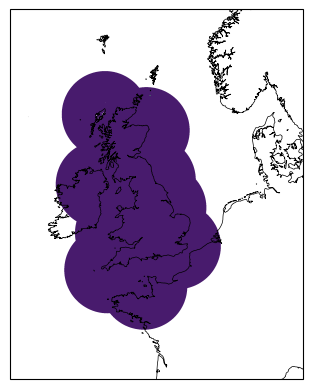

In [29]:
iplt.contourf(test_5mins[1,:,:])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5)

### 30 mins regridded

In [48]:
test_30mins_rg = iris.load("/nfs/a319/gy17m2a/PhD/datadir/NIMROD/30mins/NIMROD_regridded_2.2km/NearestNeighbour/2009/rg_metoffice-c-band-rain-radar_uk_20090601_30mins.nc")
test_30mins_rg= test_30mins_rg[0]
test_30mins_rg_leeds = trim_to_bbox_of_region_regriddedobs(test_30mins_rg, leeds_at_centre_gdf)
test_30mins_rg_uk = trim_to_bbox_of_region_regriddedobs(test_30mins_rg, uk_gdf)

In [49]:
print(np.nanmin(test_30mins_rg_uk.data))
print(np.nanmax(test_30mins_rg_uk.data))

-170.66667
55.682293


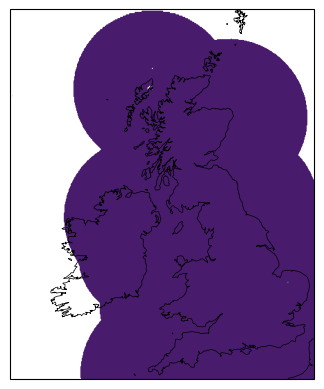

In [30]:
iplt.contourf(test_30mins_rg_uk[1,:,:])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5)

### 30 mins (1km)

In [13]:
test_30mins = iris.load("/nfs/a319/gy17m2a/PhD/datadir/NIMROD/30mins/OriginalFormat_1km/2009/metoffice-c-band-rain-radar_uk_20090601_30mins.nc")
test_30mins= test_30mins[0]
test_30mins_leeds = trim_to_bbox_of_region_obs(test_30mins, leeds_at_centre_gdf)
test_30mins_uk = trim_to_bbox_of_region_obs(test_30mins, uk_gdf)

In [18]:
print(np.nanmin(test_30mins_uk.data))
print(np.nanmax(test_30mins_uk.data))

-170.66667
144.32292


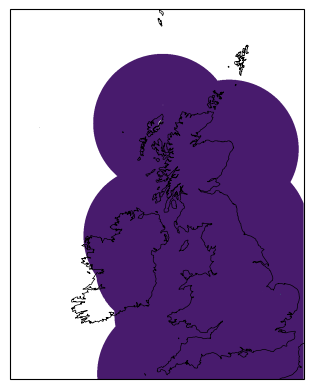

In [31]:
iplt.contourf(test_30mins_uk[1,:,:])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5)

### Check with animation - consistent colorbar

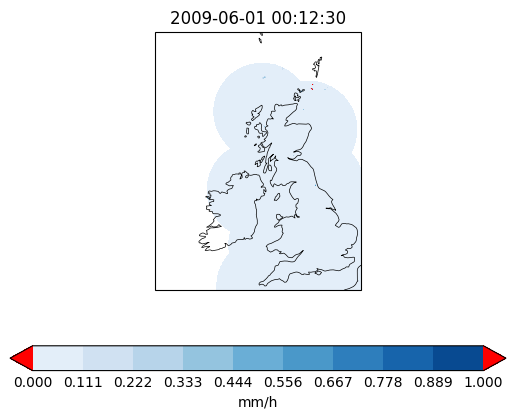

In [53]:
###############################################################################
# Animate a month's worth of data over whole UK
###############################################################################  
levels = np.linspace(0, 1,10)
colors = plt.get_cmap("Blues")(np.linspace(0,1,len(levels)+1))
precip_colormap, norm = mcolors.from_levels_and_colors(levels, colors, extend="both")
precip_colormap.set_under(color="red")
precip_colormap.set_over(color="red")

# Create a figure
fig = plt.figure()

frames = month_uk_cube.shape[0]   # Number of frames
min_value = month_uk_cube.data.min()  # Lowest value
max_value = month_uk_cube.data.max()  # Highest value

    
def draw(frame):
    # Clear the previous figure, so that the colourbars dont overlay each other.
    plt.clf()
    # Extract one hour 
    hour = month_uk_cube[frame]
    #  Alternative using the Iris plotting functions
    # hour.data = np.flipud(hour.data)
    contour = qplt.pcolormesh(hour, cmap=precip_colormap, norm=norm)
    #contour = qplt.contourf(hour, cmap=precip_colormap, vmin = 0, vmax = 20)
    # contour = plt.axes().set_aspect('equal') 
    # plt.plot(rv_closest_idx_fl[1], rv_closest_idx_fl[0], 'o', color='black', markersize = 3) 
    plt.gca().coastlines(resolution='50m', color='black', linewidth=0.5)
    # plt.plot(53.802070, -1.588941, 'o', color='black', markersize = 10) 
      
    # Create datetime in human readable format
    datetime = hour.coord('time').units.num2date(hour.coord('time').points[0]) 
    
    title = u"%s — %s" % (hour.long_name, str(datetime))
    title = str(datetime)
    plt.title(title)
    return contour
    
def init():
    return draw(0)

def animate(frame):
    return draw(frame)


# Not sure what, if anything, this does
from matplotlib import rc, animation
rc('animation', html='html5')

ani = animation.FuncAnimation(fig, animate, frames, interval=10, save_count=50, blit=False, init_func=init,repeat=False)
ani.save('/nfs/a319/gy17m2a/PhD/consistent_cmap.mp4', writer=animation.FFMpegWriter(fps=8))


### Not consistent colorbar

In [50]:
month_uk_cube = test_30mins_uk
month_uk_cube

Rainfall Rate Composite (mm/h),time,projection_y_coordinate,projection_x_coordinate
Shape,48,1354,1076
Dimension coordinates,,,
time,x,-,-
projection_y_coordinate,-,x,-
projection_x_coordinate,-,-,x
Auxiliary coordinates,,,
forecast_reference_time,x,-,-
hour,x,-,-
Scalar coordinates,,,forecast_period 0 second
Cell methods,,,


/tmp/ipykernel_12232/1566994078.py:53: UserWarning: You passed in an explicit save_count=50 which is being ignored in favor of frames=48.
  ani = animation.FuncAnimation(fig, animate, frames, interval=10, save_count=50, blit=False, init_func=init,repeat=False)
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/python3.9/site-packages/iris/coords.py:1806: UserWarning: Coordinate 'projection_x_coordinate' is not bounded, guessing contiguous bounds.
  warnings.warn(
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/python3.9/site-packages/iris/coords.py:1806: UserWarning: Coordinate 'projection_y_coordinate' is not bounded, guessing contiguous bounds.
  warnings.warn(
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/python3.9/site-packages/iris/coords.py:1806: UserWarning: Coordinate 'projection_x_coordinate' is not bounded, guessing contiguous bounds.
  warnings.warn(
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/pyt

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/python3.9/site-packages/iris/coords.py:1806: UserWarning: Coordinate 'projection_x_coordinate' is not bounded, guessing contiguous bounds.
  warnings.warn(
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/python3.9/site-packages/iris/coords.py:1806: UserWarning: Coordinate 'projection_y_coordinate' is not bounded, guessing contiguous bounds.
  warnings.warn(
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/python3.9/site-packages/iris/coords.py:1806: UserWarning: Coordinate 'projection_x_coordinate' is not bounded, guessing contiguous bounds.
  warnings.warn(
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/python3.9/site-packages/iris/coords.py:1806: UserWarning: Coordinate 'projection_y_coordinate' is not bounded, guessing contiguous bounds.
  warnings.warn(
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/python3.9/site-packages/iris/coords.py:18

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/python3.9/site-packages/iris/coords.py:1806: UserWarning: Coordinate 'projection_x_coordinate' is not bounded, guessing contiguous bounds.
  warnings.warn(
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/python3.9/site-packages/iris/coords.py:1806: UserWarning: Coordinate 'projection_y_coordinate' is not bounded, guessing contiguous bounds.
  warnings.warn(
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/python3.9/site-packages/iris/coords.py:1806: UserWarning: Coordinate 'projection_x_coordinate' is not bounded, guessing contiguous bounds.
  warnings.warn(
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/python3.9/site-packages/iris/coords.py:1806: UserWarning: Coordinate 'projection_y_coordinate' is not bounded, guessing contiguous bounds.
  warnings.warn(
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/python3.9/site-packages/iris/coords.py:18

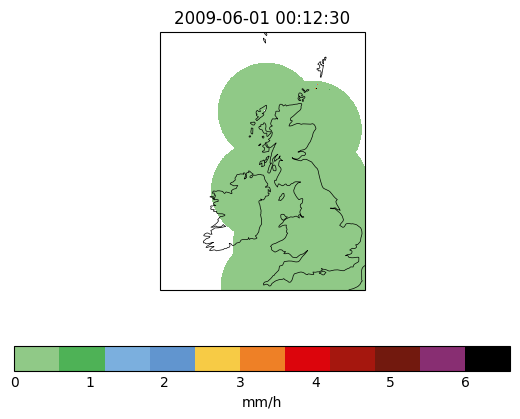

In [51]:
###############################################################################
# Animate a month's worth of data over whole UK
###############################################################################  
# Create a colourmap                                   
tol_precip_colors = ["#90C987", "#4EB256","#7BAFDE", "#6195CF", "#F7CB45", "#EE8026", "#DC050C", "#A5170E",
"#72190E","#882E72","#000000"]                                      

precip_colormap = matplotlib.colors.ListedColormap(tol_precip_colors)
precip_colormap.set_under(color="red")
precip_colormap.set_over(color="red")

# Create a figure
fig = plt.figure()

frames = month_uk_cube.shape[0]   # Number of frames
min_value = month_uk_cube.data.min()  # Lowest value
max_value = month_uk_cube.data.max()  # Highest value

    
def draw(frame):
    # Clear the previous figure, so that the colourbars dont overlay each other.
    plt.clf()
    # Extract one hour 
    hour = month_uk_cube[frame]
    #  Alternative using the Iris plotting functions
    # hour.data = np.flipud(hour.data)
    contour = qplt.pcolormesh(hour, cmap=precip_colormap)
    #contour = qplt.contourf(hour, cmap=precip_colormap, vmin = 0, vmax = 20)
    # contour = plt.axes().set_aspect('equal') 
    # plt.plot(rv_closest_idx_fl[1], rv_closest_idx_fl[0], 'o', color='black', markersize = 3) 
    plt.gca().coastlines(resolution='50m', color='black', linewidth=0.5)
    # plt.plot(53.802070, -1.588941, 'o', color='black', markersize = 10) 
      
    # Create datetime in human readable format
    datetime = hour.coord('time').units.num2date(hour.coord('time').points[0]) 
    
    title = u"%s — %s" % (hour.long_name, str(datetime))
    title = str(datetime)
    plt.title(title)
    return contour
    
def init():
    return draw(0)

def animate(frame):
    return draw(frame)


# Not sure what, if anything, this does
from matplotlib import rc, animation
rc('animation', html='html5')

ani = animation.FuncAnimation(fig, animate, frames, interval=10, save_count=50, blit=False, init_func=init,repeat=False)
ani.save('/nfs/a319/gy17m2a/PhD/changing_cmap.mp4', writer=animation.FFMpegWriter(fps=8))
